In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl


%matplotlib inline

In [2]:
df=wisps.datasets['candidates']

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


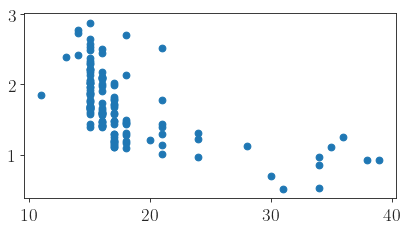

In [3]:
plt.scatter(df.spt.apply(splat.typeToNum), df.snr2.apply(np.log10))

In [4]:
#df.

In [5]:
cols=['snr1', 'snr2', 'grism_id', 'spt',
       'F110', 'F140', 'F160', 'RA', 'DEC', 'survey',  'f_test',
       'pointing', 'exposure', 'spectra']

In [6]:
df=df[df.spt.apply(splat.typeToNum)>19.0]

In [37]:
#df['spectra']=df.grism_id.apply(lambda x: wisps.Source(name=x))
#df['spectra'].to_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs.pkl')

In [8]:
df['spectra']=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs.pkl')

In [9]:
len(df)

21

In [10]:
ca_df=df[cols]

In [11]:
ca_df['f_test']=ca_df.f_test.apply(lambda x: round(x, 2))

In [12]:
f110s=np.array(np.apply_along_axis(list, 0, ca_df.F110.str.replace('nan', '0').apply(eval).values))[:,0]
f110_ers=np.array(np.apply_along_axis(list, 0, ca_df.F110.str.replace('nan', '0').apply(eval).values))[:,1]
f140s=np.array(np.apply_along_axis(list, 0, ca_df.F140.str.replace('nan', '0').apply(eval).values))[:,0]
f140_ers=np.array(np.apply_along_axis(list, 0, ca_df.F140.str.replace('nan', '0').apply(eval).values))[:,1]
f160s=np.array(np.apply_along_axis(list, 0, ca_df.F160.str.replace('nan', '0').apply(eval).values))[:,0]
f160_ers=np.array(np.apply_along_axis(list, 0, ca_df.F160.str.replace('nan', '0').apply(eval).values))[:,1]

In [13]:
ca_df=ca_df.drop(['F110', 'F140', 'F160'], axis=1)

In [14]:
ca_df['F110W']=np.round(f110s, 2)
ca_df['F110W_ER']=np.round(f110_ers, 2)

ca_df['F140W']=np.round(f140s, 2)
ca_df['F140W_ER']=np.round(f140_ers, 2)

ca_df['F160W']=np.round(f160s, 2)
ca_df['F160W_ER']=np.round(f160_ers, 2)

In [15]:
ca_df[['F110W','F110W_ER', 'F140W','F140W_ER', 'F160W','F160W_ER' ]]=ca_df[['F110W','F110W_ER', 'F140W','F140W_ER', 'F160W','F160W_ER' ]].apply(lambda x: x.replace(float(0), np.nan), axis=0)

In [16]:
ca_df=ca_df.drop_duplicates('grism_id')

In [17]:
ncaddf=ca_df[ca_df.spt.apply(splat.typeToNum)>19.0]
ncaddf['distance']=ncaddf.spectra.apply(lambda x: x.distance['val'].value)
ncaddf['distance_er']=ncaddf.spectra.apply(lambda x: x.distance['er'].value)
ncaddf['shortname']=ncaddf.spectra.apply(lambda x: x.shortname)

In [18]:
fdf=ncaddf.sort_values(['spt']).reset_index(drop=True)

In [19]:
fdf[['distance','distance_er', 'snr1', 'snr2']]=(fdf[['distance','distance_er', 'snr1', 'snr2']]).applymap(np.round)

In [20]:
colors=wisps.Annotator.color_from_spts(fdf.spt, cmap='viridis')

In [21]:
len(fdf)

21

In [22]:
#np.

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


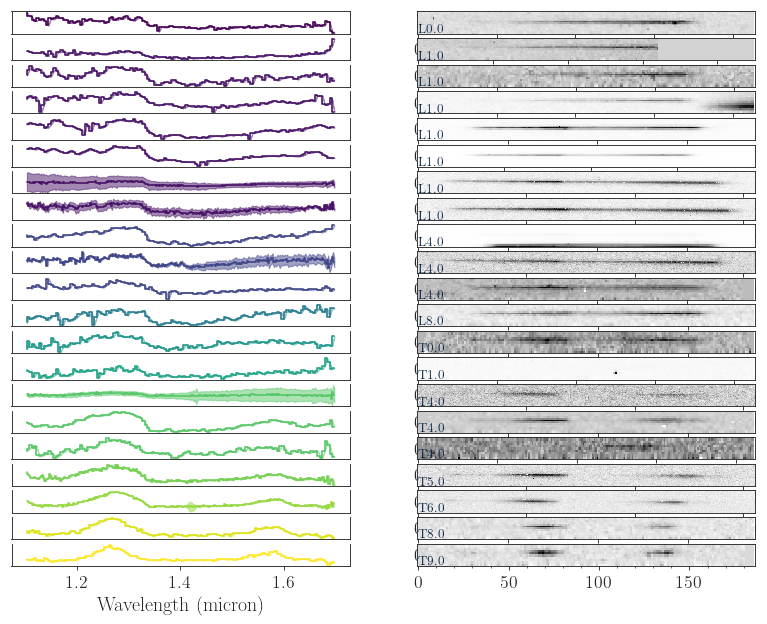

In [23]:
fig, ax=plt.subplots(nrows=len(fdf),ncols=2, figsize=(8*1.5, 6*1.5), sharex=False, sharey=False)

    
for idx, row in fdf.iterrows():
    s=row.spectra
    s.normalize(waverange=[1.15,1.65])
    #s.normalize()
    mask=np.where((s.wave>1.1) & (s.wave<1.7))[0]
    a=None
    
    a=ax[idx][0]
    
    a.step(s.wave[mask], (s.flux[mask]), color=colors[idx])
    a.fill_between(s.wave[mask],s.flux[mask]-10.*s.contamination[mask], \
                   s.flux[mask]+10.*s.contamination[mask], alpha=.5,color=colors[idx])
    
    b=ax[idx][1]
    b.imshow(s.spectrum_image, cmap='Greys', interpolation='nearest')
    b.set_aspect('auto')
    
   
    
    if idx == 0:
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    elif idx == len(fdf)-1:
        a.spines['top'].set_visible(False)
        a.set_yticks([])
        a.set_xlabel('Wavelength (micron)', fontsize=18)
        #b.set_xlabel('2D image', fontsize=18)
    else :
        a.spines['top'].set_visible(False)
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    if row.spt.lower().startswith('t'): b.text(0.0,s.spectrum_image.shape[0]-1,row.spt, fontsize=12, color='#001f3f')
    if row.spt.lower().startswith('l'): b.text(0.0, s.spectrum_image.shape[0]-1,row.spt, fontsize=12, color='#001f3f')
        
    b.set_yticks([]) 
    #b.tick_params( labelleft='off', labelbottom='off')

#ax.yaxis.set_ticks_position('both')
#ax.xaxis.set_ticks_position('both')

#ax1.yaxis.set_ticks_position('both')
#ax1.xaxis.set_ticks_position('both')

#ax.tick_params(which='major',direction='inout')
#ax.tick_params(which='minor', direction='in')

#ax1.tick_params(which='major', direction='inout')
#ax1.tick_params(which='minor',  direction='in')

#ax.set_xticks(np.arange(1.0, 2.0, 0.05), minor=True)
#ax.set_xlim([1.1, 1.7])

#ax.set_xlabel('Wavelength (micron)', fontsize=18)
#ax1.set_xlabel('Wavelength (micron)', fontsize=18)
#ax.set_ylabel('Normalized Flux + c', fontsize=18)

plt.tight_layout()
plt.minorticks_on()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidates.pdf')

In [24]:
fdf.drop(['spectra', 'exposure'], axis=1).to_latex(wisps.LIBRARIES+'/candidates2.tex', index=False, na_rep=' ' )

In [25]:
#distance distributions
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
coords=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)#.transform_to(coord.Galactocentric) 

In [26]:
x, y, z=coords.cartesian.xyz

In [27]:
r=np.sqrt(x**2+y**2)

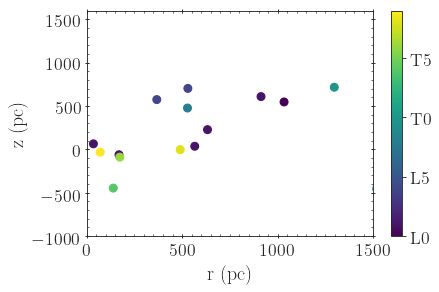

In [28]:
fig, ax=plt.subplots(figsize=(6, 4))
sc=plt.scatter(r, z, c=fdf.spt.apply(splat.typeToNum), cmap='viridis', s=50)
br=plt.colorbar(sc)
plt.ylabel('z (pc)', fontsize=18)
plt.xlabel('r (pc)', fontsize=18)
ax.set_xticks(np.arange(0, 2000, 50), minor=True)
ax.set_yticks(np.arange(-1000, 2500, 100), minor=True)

ax.set_xlim([0, 1500])
ax.set_ylim([-1000, 1600])

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.tick_params(which='major',direction='inout')
ax.tick_params(which='minor', direction='in')

br.set_ticks([20, 25, 30, 35, 40])
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf')

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


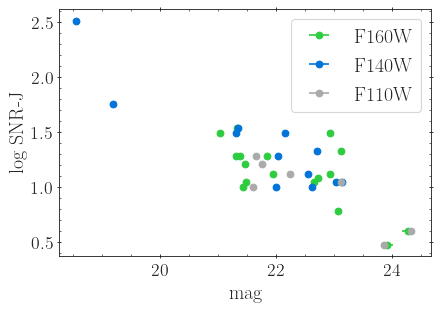

In [29]:
import seaborn as sns
fig, ax=plt.subplots(figsize=(6, 4))
ax.errorbar(fdf.F160W,  fdf.snr1.apply(np.log10), xerr=fdf.F160W_ER,fmt='o', color='#2ECC40', label='F160W' )
ax.errorbar(fdf.F140W,   fdf.snr1.apply(np.log10), xerr=fdf.F140W_ER,fmt='o', color='#0074D9', label='F140W')
ax.errorbar(fdf.F110W,   fdf.snr1.apply(np.log10), xerr=fdf.F110W_ER,fmt='o', color='#AAAAAA' , label='F110W')
#plt.xlabel('mag', fontsize=16)

plt.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='major',direction='inout')
ax.tick_params(which='minor', direction='in')

plt.legend()

plt.xlabel('mag', fontsize=18)
plt.ylabel('log SNR-J', fontsize=18)
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_distribution_candidates.pdf')

In [30]:
dhgjk=fdf.sort_values(by='distance')[['grism_id', 'distance','distance_er', 'spt']]

In [31]:
fdf.to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [36]:
df['spectra'].iloc[0].spt

'L5.0'